# CS6140 Assignment 4: Unsupervised Learning FMA data Part 2
- Student: Sukhrobbek Ilyosbekov

**Table of Contents**

1. [Data Preparation](#1)
2. [Dimension Reduction Techniques](#2)
    1. [Principal Component Analysis (PCA)](#2.1)
    2. [Uniform Manifold Approximation and Projection (UMAP)](#2.2)
    3. [t-Distributed Stochastic Neighbor Embedding (t-SNE)](#2.3)
    4. [Locally Linear Embedding (LLE)](#2.4)
    5. [ISOMAP](#2.5)
3. [Visualization](#3)
4. [Correlation Analysis](#4)
5. [Comparative Analysis](#5)

## Setup
In order to run this notebook, the following libraries should be installed:
- pandas
- matplotlib
- seaborn
- umap-learn

These libraries can be installed using the following command:
```bash
pip install pandas matplotlib seaborn numba umap-learn
```

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def get_data_path(relative_path: str) -> str:
    """
    Get the absolute path to a file in the `dataset` directory.

    Args:
        relative_path: The path to the file relative to the `dataset` directory including the file name.

    Returns:
        The full path to the file in the `dataset` directory.

    Examples:
        >>> get_data_path("assignment1/boston_listings.csv")
        "C:/Users/username/assignments/dataset/assignment1/boston_listings.csv"
    """
    return os.path.abspath(os.path.join("../../dataset", relative_path))

## Data Preparation <a class="anchor" id="1"></a>

First, load the features dataset and standardize column names since it has multi-level column names.

In [ ]:
# Load the features dataset
features_df = pd.read_csv(get_data_path("assignment4/features.csv"), header=[0, 1, 2, 3])

# Flatten the multi-row header to create a single-level column index for easier manipulation
features_df.columns = ["_".join(filter(None, col)).strip() for col in features_df.columns.values]

# Remove "_Unnamed: 1_level_3", "_Unnamed: 2_level_3" and so on using regex
features_df.columns = features_df.columns.str.replace(r"_Unnamed: \d+_level_\d+$", "", regex=True)

# Rename the column feature_statistics_number_track_id to track_id
features_df.rename(columns={"feature_statistics_number_track_id": "track_id"}, inplace=True)

print("Features dataset info:")
display(features_df.info())

print("First few rows of the features dataset:")
display(features_df.head())

Features dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106574 entries, 0 to 106573
Columns: 519 entries, track_id to zcr_std_01
dtypes: float64(518), int64(1)
memory usage: 422.0 MB


None

First few rows of the features dataset:


,track_id,chroma_cens_kurtosis_01,chroma_cens_kurtosis_02,chroma_cens_kurtosis_03,chroma_cens_kurtosis_04,chroma_cens_kurtosis_05,chroma_cens_kurtosis_06,chroma_cens_kurtosis_07,chroma_cens_kurtosis_08,chroma_cens_kurtosis_09,...,tonnetz_std_04,tonnetz_std_05,tonnetz_std_06,zcr_kurtosis_01,zcr_max_01,zcr_mean_01,zcr_median_01,zcr_min_01,zcr_skew_01,zcr_std_01
0,2,7.180653,5.230309,0.249321,1.347620,1.482478,0.531371,1.481593,2.691455,0.866868,...,0.054125,0.012226,0.012111,5.758890,0.459473,0.085629,0.071289,0.000000,2.089872,0.061448
1,3,1.888963,0.760539,0.345297,2.295201,1.654031,0.067592,1.366848,1.054094,0.108103,...,0.063831,0.014212,0.017740,2.824694,0.466309,0.084578,0.063965,0.000000,1.716724,0.069330
2,5,0.527563,-0.077654,-0.279610,0.685883,1.937570,0.880839,-0.923192,-0.927232,0.666617,...,0.040730,0.012691,0.014759,6.808415,0.375000,0.053114,0.041504,0.000000,2.193303,0.044861
3,10,3.702245,-0.291193,2.196742,-0.234449,1.367364,0.998411,1.770694,1.604566,0.521217,...,0.074358,0.017952,0.013921,21.434212,0.452148,0.077515,0.071777,0.000000,3.542325,0.040800
4,20,-0.193837,-0.198527,0.201546,0.258556,0.775204,0.084794,-0.289294,-0.816410,0.043851,...,0.095003,0.022492,0.021355,16.669037,0.469727,0.047225,0.040039,0.000977,3.189831,0.030993


Extract domain features and save them in a separate dataframe. Since the features are already normalized, we don"t need to normalize them again.

In [3]:
# Select domains for dimensionality reduction
domains_to_extract = ["chroma", "mfcc", "spectral", "tonnetz"]

# Initialize a list to hold the extracted columns
extracted_columns = []

# Loop through the columns and filter based on the selected domains
for col in features_df.columns:
    for domain in domains_to_extract:
        if domain in col:
            extracted_columns.append(col)
            break

# Modify the features dataframe to include only the extracted columns
features_df = features_df[extracted_columns]

# Display the shape and a preview of the extracted features
print("Shape of extracted features for selected domains:", features_df.shape)
display(features_df.head())

Shape of extracted features for selected domains: (106574, 504)


,chroma_cens_kurtosis_01,chroma_cens_kurtosis_02,chroma_cens_kurtosis_03,chroma_cens_kurtosis_04,chroma_cens_kurtosis_05,chroma_cens_kurtosis_06,chroma_cens_kurtosis_07,chroma_cens_kurtosis_08,chroma_cens_kurtosis_09,chroma_cens_kurtosis_10,...,tonnetz_skew_03,tonnetz_skew_04,tonnetz_skew_05,tonnetz_skew_06,tonnetz_std_01,tonnetz_std_02,tonnetz_std_03,tonnetz_std_04,tonnetz_std_05,tonnetz_std_06
0,7.180653,5.230309,0.249321,1.347620,1.482478,0.531371,1.481593,2.691455,0.866868,1.341231,...,0.200944,0.593595,-0.177665,-1.424201,0.019809,0.029569,0.038974,0.054125,0.012226,0.012111
1,1.888963,0.760539,0.345297,2.295201,1.654031,0.067592,1.366848,1.054094,0.108103,0.619185,...,0.171930,-0.990710,0.574556,0.556494,0.026316,0.018708,0.051151,0.063831,0.014212,0.017740
2,0.527563,-0.077654,-0.279610,0.685883,1.937570,0.880839,-0.923192,-0.927232,0.666617,1.038546,...,-0.419971,-0.014541,-0.199314,-0.925733,0.025550,0.021106,0.084997,0.040730,0.012691,0.014759
3,3.702245,-0.291193,2.196742,-0.234449,1.367364,0.998411,1.770694,1.604566,0.521217,1.982386,...,0.015767,-1.094873,1.164041,0.246746,0.021413,0.031989,0.088197,0.074358,0.017952,0.013921
4,-0.193837,-0.198527,0.201546,0.258556,0.775204,0.084794,-0.289294,-0.816410,0.043851,-0.804761,...,0.081732,0.040777,0.232350,-0.207831,0.033342,0.035174,0.105521,0.095003,0.022492,0.021355


## Dimension Reduction Techniques <a class="anchor" id="2"></a>


### 1. Principal Component Analysis (PCA) <a class="anchor" id="2.1"></a>

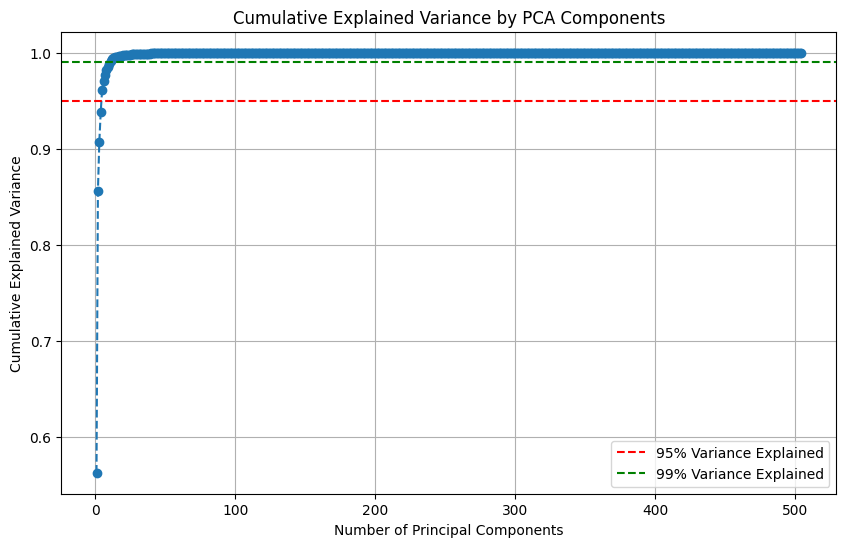

Number of components for 95% variance: 5
Number of components for 99% variance: 11


In [ ]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(features_df)

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = explained_variance_ratio.cumsum()

# Plot explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance, marker="o", linestyle="--")
plt.title("Cumulative Explained Variance by PCA Components")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.axhline(y=0.95, color="r", linestyle="--", label="95% Variance Explained")
plt.axhline(y=0.99, color="g", linestyle="--", label="99% Variance Explained")
plt.legend()
plt.grid()
plt.show()

# Print the number of components for 95% and 99% variance
components_95 = (cumulative_variance >= 0.95).argmax() + 1
components_99 = (cumulative_variance >= 0.99).argmax() + 1
print(f"Number of components for 95% variance: {components_95}")
print(f"Number of components for 99% variance: {components_99}")

In [9]:
# Perform PCA with the number of components that explain 95% of the variance
pca = PCA(n_components=components_95)
features_pca = pca.fit_transform(features_df)

print("Shape of PCA-transformed features:", features_pca.shape)

Shape of PCA-transformed features: (106574, 5)


### 2. Uniform Manifold Approximation and Projection (UMAP) <a class="anchor" id="2.2"></a>

In [6]:
import umap

# Apply UMAP for 2D and 3D
umap_2d = umap.UMAP(n_components=2).fit_transform(features_df)
umap_3d = umap.UMAP(n_components=3).fit_transform(features_df)

# Save UMAP results for visualization
umap_reduction = {"2D": umap_2d, "3D": umap_3d}
print("UMAP reduction results:")
print("2D shape:", umap_2d.shape)
print("3D shape:", umap_3d.shape)

UMAP reduction results:
2D shape: (106574, 2)
3D shape: (106574, 3)


### 3. t-Distributed Stochastic Neighbor Embedding (t-SNE) <a class="anchor" id="2.3"></a>

In [10]:
from sklearn.manifold import TSNE

# Apply t-SNE for 2D and 3D
tsne_2d = TSNE(n_components=2, perplexity=30, n_jobs=-1).fit_transform(features_pca)
tsne_3d = TSNE(n_components=3, perplexity=30, n_jobs=-1).fit_transform(features_pca)

# Save t-SNE results for visualization
tsne_reduction = {"2D": tsne_2d, "3D": tsne_3d}
print("TSNE reduction results:")
print("2D shape:", tsne_2d.shape)
print("3D shape:", tsne_3d.shape)

KeyboardInterrupt: 

### 4. Locally Linear Embedding (LLE) <a class="anchor" id="2.4"></a>

In [ ]:
from sklearn.manifold import LocallyLinearEmbedding

# Apply LLE for 2D and 3D
lle_2d = LocallyLinearEmbedding(n_components=2, n_jobs=-1).fit_transform(features_df)
lle_3d = LocallyLinearEmbedding(n_components=3, n_jobs=-1).fit_transform(features_df)

# Save LLE results for visualization
lle_reduction = {"2D": lle_2d, "3D": lle_3d}
print("LLE reduction results:")
print("2D shape:", lle_2d.shape)
print("3D shape:", lle_3d.shape)

### 5. ISOMAP <a class="anchor" id="2.5"></a>

In [4]:
from sklearn.manifold import Isomap

# Apply ISOMAP for 2D and 3D
isomap_2d = Isomap(n_components=2, n_jobs=-1).fit_transform(features_df)
isomap_3d = Isomap(n_components=3, n_jobs=-1).fit_transform(features_df)

# Save ISOMAP results for visualization
isomap_reduction = {"2D": isomap_2d, "3D": isomap_3d}
print("ISOMAP reduction results:")
print("2D shape:", isomap_2d.shape)
print("3D shape:", isomap_3d.shape)

c:\Users\suxro\source\Courses\CS6140\cs6140-assignments\assignments\.venv\Lib\site-packages\sklearn\manifold\_isomap.py:383: UserWarning: The number of connected components of the neighbors graph is 11 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\suxro\source\Courses\CS6140\cs6140-assignments\assignments\.venv\Lib\site-packages\scipy\sparse\_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\suxro\source\Courses\CS6140\cs6140-assignments\assignments\.venv\Lib\site-packages\scipy\sparse\_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\suxro\source\Courses\CS6140\cs6140-assignments\assignments\.venv\Lib\site-packages\scipy\sparse

MemoryError: Unable to allocate 84.6 GiB for an array with shape (106574, 106574) and data type float64

## Visualization <a class="anchor" id="3"></a>

### Extracting genre labels

In [ ]:
# Load the tracks dataset
tracks_df = pd.read_csv(get_data_path("assignment4/tracks.csv"))

# Ensure that the genres are properly cleaned and converted to categories
tracks_df["track_genre_top"] = tracks_df["track_genre_top"].astype("category")

# Map genre names to numeric labels
genre_labels = tracks_df["track_genre_top"].cat.codes

# Map numeric labels back to genre names (for reference)
genre_mapping = dict(enumerate(tracks_df["track_genre_top"].cat.categories))

print("Genre mapping:", genre_mapping)

# Drop NaN genres and align with features dataset
tracks_with_genres = tracks_df.dropna(subset=["track_genre_top"])
features_with_genres = features_df.merge(
    tracks_with_genres[["track_id", "track_genre_top"]], on="track_id"
)

# Extract updated genre labels after alignment
genre_labels = features_with_genres["track_genre_top"].cat.codes

print("First few genre labels:", genre_labels.head())

### 2D Visualization of Dimension Reduction Techniques

In [ ]:
from pandas import Series

# Function to create a 2D scatter plot
def plot_2d_scatter(data: np.ndarray, labels: Series[int], title: str) -> None:
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(data[:, 0], data[:, 1], c=labels, cmap="tab10", s=10, alpha=0.7)
    plt.colorbar(scatter, label="Genres")
    plt.title(title, fontsize=14)
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.show()

# Visualize 2D PCA
plot_2d_scatter(pca_reduction["2D"], genre_labels, "PCA (2D) Visualization")

# Visualize 2D UMAP
plot_2d_scatter(umap_reduction["2D"], genre_labels, "UMAP (2D) Visualization")

# Visualize 2D t-SNE
#plot_2d_scatter(tsne_reduction["2D"], genre_labels, "t-SNE (2D) Visualization")

# Visualize 2D LLE
plot_2d_scatter(lle_reduction["2D"], genre_labels, "LLE (2D) Visualization")

# Visualize 2D ISOMAP
plot_2d_scatter(isomap_reduction["2D"], genre_labels, "ISOMAP (2D) Visualization")

### 3D Visualization of Dimension Reduction Techniques

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Function to create a 3D scatter plot
def plot_3d_scatter(data: np.ndarray, labels: Series[int], title: str) -> None:
    fig = plt.figure(figsize=(10, 8))
    ax: Axes3D = fig.add_subplot(111, projection="3d")
    scatter = ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=labels, cmap="tab10", s=10, alpha=0.7)
    fig.colorbar(scatter, label="Genres")
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Dimension 1")
    ax.set_ylabel("Dimension 2")
    ax.set_zlabel("Dimension 3")
    plt.show()

# Visualize 3D PCA
plot_3d_scatter(pca_reduction["3D"], genre_labels, "PCA (3D) Visualization")

# Visualize 3D UMAP
plot_3d_scatter(umap_reduction["3D"], genre_labels, "UMAP (3D) Visualization")

# Visualize 3D t-SNE
#plot_3d_scatter(tsne_reduction["3D"], genre_labels, "t-SNE (3D) Visualization")

# Visualize 3D LLE
plot_3d_scatter(lle_reduction["3D"], genre_labels, "LLE (3D) Visualization")

# Visualize 3D ISOMAP
plot_3d_scatter(isomap_reduction["3D"], genre_labels, "ISOMAP (3D) Visualization")

## Correlation Analysis <a class="anchor" id="4"></a>

In [ ]:
# Function to calculate and visualize correlations for reduced data
def analyze_correlations(data_2d: np.DataFrame, data_3d: pd.DataFrame, method_name: str) -> None:
    print(f"\nCorrelation Analysis for {method_name} (2D):")
    corr_2d = data_2d.corr()
    display(corr_2d)

    print(f"\nCorrelation Analysis for {method_name} (3D):")
    corr_3d = data_3d.corr()
    display(corr_3d)

    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Heatmap for 2D correlations
    sns.heatmap(corr_2d, annot=True, cmap="coolwarm", ax=axes[0])
    axes[0].set_title(f"{method_name} - 2D Correlation Heatmap")
    
    # Heatmap for 3D correlations
    sns.heatmap(corr_3d, annot=True, cmap="coolwarm", ax=axes[1])
    axes[1].set_title(f"{method_name} - 3D Correlation Heatmap")
    
    plt.tight_layout()
    plt.show()

pca_2d_df = pd.DataFrame(pca_reduction["2D"], columns=["PC1", "PC2"])
pca_3d_df = pd.DataFrame(pca_reduction["3D"], columns=["PC1", "PC2", "PC3"])

umap_2d_df = pd.DataFrame(umap_reduction["2D"], columns=["UMAP1", "UMAP2"])
umap_3d_df = pd.DataFrame(umap_reduction["3D"], columns=["UMAP1", "UMAP2", "UMAP3"])

# tsne_2d_df = pd.DataFrame(tsne_reduction["2D"], columns=["t-SNE1", "t-SNE2"])
# tsne_3d_df = pd.DataFrame(tsne_reduction["3D"], columns=["t-SNE1", "t-SNE2", "t-SNE3"])

lle_2d_df = pd.DataFrame(lle_reduction["2D"], columns=["LLE1", "LLE2"])
lle_3d_df = pd.DataFrame(lle_reduction["3D"], columns=["LLE1", "LLE2", "LLE3"])

isomap_2d_df = pd.DataFrame(isomap_reduction["2D"], columns=["ISOMAP1", "ISOMAP2"])
isomap_3d_df = pd.DataFrame(isomap_reduction["3D"], columns=["ISOMAP1", "ISOMAP2", "ISOMAP3"])

# Analyze correlations for each method
analyze_correlations(pca_2d_df, pca_3d_df, "PCA")
analyze_correlations(umap_2d_df, umap_3d_df, "UMAP")
#analyze_correlations(tsne_2d_df, tsne_3d_df, "t-SNE")
analyze_correlations(lle_2d_df, lle_3d_df, "LLE")
analyze_correlations(isomap_2d_df, isomap_3d_df, "ISOMAP")

## Comparative Analysis <a class="anchor" id="5"></a>